Copyright (c) 2015, 2016 [Sebastian Raschka](http://sebastianraschka.com/)
<br>
[Li-Yi Wei](http://liyiwei.org/)

https://github.com/1iyiwei/pyml

[MIT License](https://github.com/1iyiwei/pyml/blob/master/LICENSE.txt)

# Python Machine Learning - Code Examples

# Chapter 5 - Compressing Data via Dimensionality Reduction

Principle component analysis (PCA)
* unsupervised

Linear discriminant analysis (LDA)
* supervised

Kernel PCA
* non-linear mapping

Note that the optional watermark extension is a small IPython notebook plugin that I developed to make the code reproducible. You can just skip the following line(s).

In [1]:
%load_ext watermark
%watermark -a '' -u -d -v -p numpy,scipy,matplotlib,sklearn

last updated: 2016-10-12 

CPython 3.5.2
IPython 4.2.0

numpy 1.11.1
scipy 0.17.1
matplotlib 1.5.1
sklearn 0.18


*The use of `watermark` is optional. You can install this IPython extension via "`pip install watermark`". For more information, please see: https://github.com/rasbt/watermark.*

### Overview

- [Unsupervised dimensionality reduction via principal component analysis](#Unsupervised-dimensionality-reduction-via-principal-component-analysis-128)
  - [Total and explained variance](#Total-and-explained-variance)
  - [Feature transformation](#Feature-transformation)
  - [Principal component analysis in scikit-learn](#Principal-component-analysis-in-scikit-learn)
- [Supervised data compression via linear discriminant analysis](#Supervised-data-compression-via-linear-discriminant-analysis)
  - [Computing the scatter matrices](#Computing-the-scatter-matrices)
  - [Selecting linear discriminants for the new feature subspace](#Selecting-linear-discriminants-for-the-new-feature-subspace)
  - [Projecting samples onto the new feature space](#Projecting-samples-onto-the-new-feature-space)
  - [LDA via scikit-learn](#LDA-via-scikit-learn)
- [Using kernel principal component analysis for nonlinear mappings](#Using-kernel-principal-component-analysis-for-nonlinear-mappings)
  - [Kernel functions and the kernel trick](#Kernel-functions-and-the-kernel-trick)
  - [Implementing a kernel principal component analysis in Python](#Implementing-a-kernel-principal-component-analysis-in-Python)
    - [Example 1 – separating half-moon shapes](#Example-1-–-separating-half-moon-shapes)
    - [Example 2 – separating concentric circles](#Example-2-–-separating-concentric-circles)
  - [Projecting new data points](#Projecting-new-data-points)
  - [Kernel principal component analysis in scikit-learn](#Kernel-principal-component-analysis-in-scikit-learn)
- [Summary](#Summary)

In [2]:
from IPython.display import Image

%matplotlib inline

# Unsupervised dimensionality reduction via principal component analysis

<img src='./images/05_01.png' width=40% align=left> 

PCA is a common way to reduce dimensionality of a given dataset.
It can also be considered as a unsupervised learning method.

Given the input data matrix $\mathbf{X}$ 

Goal: find a transformation matrix $\mathbf{W}$ that will project each row $\mathbf{x}$ of $\mathbf{X}$ into a lower dimensional vector $\mathbf{z}$ so that the variances of the projected components are maximized:
$$\mathbf{z} = \mathbf{x} \mathbf{W}$$

$\mathbf{X}$: size $n \times d$ where $n$ is the number of data samples and $d$ is the input data dimensionality 

$\mathbf{W}$: size $d \times k$

$\mathbf{z}$ and $\mathbf{x}$ are both row vectors with dimensionality $k$ and $d$, usually $k << d$.

In this 2D example, we want to project the dataset into 1D. 
We will pick the first principle component (PC1) as it maximizes variance among projected samples.

With $\mathbf{W}$, we can project the entire input $\mathbf{X}$ into a lower dimensional space data set as:
$$\mathbf{Z} = \mathbf{X} \mathbf{W}$$

<!--
The total projected dataset $\mathbf{Z}$ can be computed from the total original dataset $\mathbf{X}$:
$$
\mathbf{Z} = \mathbf{X} \mathbf{W}
$$
-->

$\mathbf{Z}$: size $n \times k$

We can also recover an approximated version $\mathbf{X'}$ of $\mathbf{X}$ from $\mathbf{Z}$ and $\mathbf{W}$ as:
$$\mathbf{X'} = \mathbf{Z} \mathbf{W}^T$$

It can be shown that $\mathbf{X'}$ is the best approximation of $\mathbf{X}$, i.e. minimizing
$$||\mathbf{X'} - \mathbf{X}||^2$$

## Algorithm

$$
\mathbf{Z} = \mathbf{X} \mathbf{W}
$$

$\mathbf{W}$ can be computed from $\mathbf{X}$ as follows.

First, compute the $d \times d$ covariance matrix $\Sigma$ from the columns (i.e. features) of $\mathbf{X}$:
$$
\begin{align}
\Sigma_{ij} = \frac{1}{n} \left(\mathbf{x_{(i)}} - \mu_i\right)^T \left(\mathbf{x_{(j)}} - \mu_j\right) 
\end{align}
$$
, where 
* $\Sigma_{ij}$ is the $(i, j)$th component of $\Sigma$.
* $\mathbf{x_{(i)}}$ is the $i^{th}$ column/feature of $\mathbf{X}$ and $\mu_i$ its mean (a scalar).

Alternatively we can compute $\Sigma$ by summing the covariance matrices of each individual sample $x^{(i)}$ (rows of $\mathbf{X}$):
$$
\begin{align}
\Sigma = \frac{1}{n} \sum_i \left(\mathbf{x^{(i)}} - \mu\right)^T \left( \mathbf{x^{(i)} - \mu}\right)
\end{align}
$$
, where $\mu$ is the (vector) mean of all rows of $\mathbf{X}$.

We then compute the eigen-values/vectors of $\Sigma$.

<font color="blue">
Recall $\mathbf{v}$ is an eigen-vector of a matrix $\Sigma$ with eigen-value $\lambda$ if
$$\lambda \mathbf{v} = \Sigma \mathbf{v}$$
That is, an eigen-vector remains itself after transforming by the matrix.
</font>

$\mathbf{W}$ can be constructed by horizontally stacking (as columns) the eigen-vectors of $\Sigma$ with the $k$ largest eigen-values (which we assume are all non-negative) as columns.

These columns are called the principle components, and thus the name principle component analysis (PCA).

## Math

Let's try to find the first principle component $\mathbf{w_1}$ so that when the input vector $\mathbf{x}$ is projected into $\mathbf{z}$ its variance is maximized:
$$\mathbf{z} = \mathbf{w_1}^T \mathbf{x}$$

$\mathbf{x}$ differnt rows of the matrix $\mathbf{X}$ verticalized as columns.

Consider $\mathbf{x}$ as a random vector that can take values from $\mathbf{X}$:
<!--
(Machine learning can be understood via a probabilistic approach from ground up, but I prefer the non-probabilistic approach to reduce potential confusion for beginners.)
-->
$$
\begin{align}
Var(\mathbf{z}) &= E\left( \left(\mathbf{w_1}^T (\mathbf{x} - \mu)\right)^2 \right)
\\
&= E\left( \mathbf{w_1}^T (\mathbf{x} - \mu) (\mathbf{x} - \mu)^T \mathbf{w_1} \right)
\\
&= \mathbf{w_1}^T \Sigma \mathbf{w_1}
\end{align}
$$

We want to find $\mathbf{w_1}$ to maximize $Var(\mathbf{z})$ subject to the unit vector constraint $|\mathbf{w_1}| = 1$.

Using Lagrangian multiplier we want to maximize:
$$\mathbf{w_1}^T \Sigma \mathbf{w_1} - \alpha(\mathbf{w_1}^T\mathbf{w_1}-1)$$

Take derivative of the above with $\mathbf{w_1}$ and set it to zero we have:
$$\Sigma \mathbf{w_1} = \alpha \mathbf{w_1}$$

And thus
$$\mathbf{w_1}^T \Sigma \mathbf{w_1} = \alpha \mathbf{w_1}^T \mathbf{w_1} = \alpha$$
Which means we want to maximize $\alpha$, and thus it should be the largest eigen-value of $\Sigma$ and $\mathbf{w_1}$ the corresponding eigen-vector.

We can continue the same trick to find the rest of the principle components by making sure each new one is orthogonal to all existing ones.

## Code example for the math above

Use the wine data set as it has 13 features for dimensionality reduction

In [3]:
import pandas as pd

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines', 'Proline']

df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


<hr>

### Note:


If the link to the Wine dataset provided above does not work for you, you can find a local copy in this repository at [./../datasets/wine/wine.data](./../datasets/wine/wine.data).

Or you could fetch it via



In [4]:
df_wine = pd.read_csv('https://raw.githubusercontent.com/1iyiwei/pyml/master/code/datasets/wine/wine.data', header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 
'Alcalinity of ash', 'Magnesium', 'Total phenols', 
'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 
'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']
df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


Splitting the data into 70% training and 30% test subsets.

In [5]:
from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_version

if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import train_test_split
else:
    from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, random_state=0)

Standardizing the data.

In [6]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

---

**Note**

Accidentally, I wrote `X_test_std = sc.fit_transform(X_test)` instead of `X_test_std = sc.transform(X_test)`. In this case, it wouldn't make a big difference since the mean and standard deviation of the test set should be (quite) similar to the training set. However, as remember from Chapter 3, the correct way is to re-use parameters from the training set if we are doing any kind of transformation -- the test set should basically stand for "new, unseen" data.

My initial typo reflects a common mistake is that some people are *not* re-using these parameters from the model training/building and standardize the new data "from scratch." Here's simple example to explain why this is a problem.

Let's assume we have a simple training set consisting of 3 samples with 1 feature (let's call this feature "length"):

- train_1: 10 cm -> class_2
- train_2: 20 cm -> class_2
- train_3: 30 cm -> class_1

mean: 20, std.: 8.2

After standardization, the transformed feature values are

- train_std_1: -1.21 -> class_2
- train_std_2: 0 -> class_2
- train_std_3: 1.21 -> class_1

Next, let's assume our model has learned to classify samples with a standardized length value < 0.6 as class_2 (class_1 otherwise). So far so good. Now, let's say we have 3 unlabeled data points that we want to classify:

- new_4: 5 cm -> class ?
- new_5: 6 cm -> class ?
- new_6: 7 cm -> class ?

If we look at the "unstandardized "length" values in our training datast, it is intuitive to say that all of these samples are likely belonging to class_2. However, if we standardize these by re-computing standard deviation and and mean you would get similar values as before in the training set and your classifier would (probably incorrectly) classify samples 4 and 5 as class 2.

- new_std_4: -1.21 -> class 2
- new_std_5: 0 -> class 2
- new_std_6: 1.21 -> class 1

However, if we use the parameters from your "training set standardization," we'd get the values:

- sample5: -18.37 -> class 2
- sample6: -17.15 -> class 2
- sample7: -15.92 -> class 2

The values 5 cm, 6 cm, and 7 cm are much lower than anything we have seen in the training set previously. Thus, it only makes sense that the standardized features of the "new samples" are much lower than every standardized feature in the training set.

---

Eigendecomposition of the covariance matrix:

In [7]:
import numpy as np
cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

print('\nEigenvalues \n%s' % eigen_vals)


Eigenvalues 
[ 4.8923083   2.46635032  1.42809973  1.01233462  0.84906459  0.60181514
  0.52251546  0.08414846  0.33051429  0.29595018  0.16831254  0.21432212
  0.2399553 ]


**Note**: 

Above, I used the [`numpy.linalg.eig`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eig.html) function to decompose the symmetric covariance matrix into its eigenvalues and eigenvectors.
    <pre>>>> eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)</pre>
    This is not really a "mistake," but probably suboptimal. It would be better to use [`numpy.linalg.eigh`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eigh.html) in such cases, which has been designed for [Hermetian matrices](https://en.wikipedia.org/wiki/Hermitian_matrix). The latter always returns real  eigenvalues; whereas the numerically less stable `np.linalg.eig` can decompose nonsymmetric square matrices, you may find that it returns complex eigenvalues in certain cases. (S.R.)


### Total and explained variance

In [8]:
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

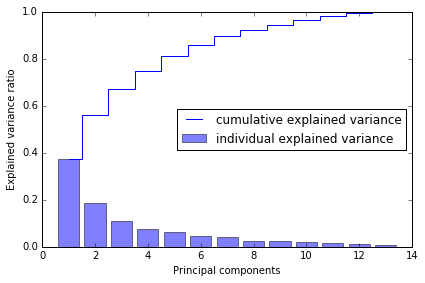

In [9]:
import matplotlib.pyplot as plt


plt.bar(range(1, 14), var_exp, alpha=0.5, align='center',
        label='individual explained variance')
plt.step(range(1, 14), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('./figures/pca1.png', dpi=300)
plt.show()

## Feature transformation

Now let's apply PCA ...

In [10]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

# Note: I added the `key=lambda k: k[0]` in the sort call above
# just like I used it further below in the LDA section.
# This is to avoid problems if there are ties in the eigenvalue
# arrays (i.e., the sorting algorithm will only regard the
# first element of the tuples, now).

In [11]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis],
               eigen_pairs[1][1][:, np.newaxis]))
print('Matrix W:\n', w)

Matrix W:
 [[ 0.14669811  0.50417079]
 [-0.24224554  0.24216889]
 [-0.02993442  0.28698484]
 [-0.25519002 -0.06468718]
 [ 0.12079772  0.22995385]
 [ 0.38934455  0.09363991]
 [ 0.42326486  0.01088622]
 [-0.30634956  0.01870216]
 [ 0.30572219  0.03040352]
 [-0.09869191  0.54527081]
 [ 0.30032535 -0.27924322]
 [ 0.36821154 -0.174365  ]
 [ 0.29259713  0.36315461]]


**Note**
Depending on which version of NumPy and LAPACK you are using, you may obtain the the Matrix W with its signs flipped. E.g., the matrix shown in the book was printed as:

```
[[ 0.14669811  0.50417079]
[-0.24224554  0.24216889]
[-0.02993442  0.28698484]
[-0.25519002 -0.06468718]
[ 0.12079772  0.22995385]
[ 0.38934455  0.09363991]
[ 0.42326486  0.01088622]
[-0.30634956  0.01870216]
[ 0.30572219  0.03040352]
[-0.09869191  0.54527081]
```

Please note that this is not an issue: If $v$ is an eigenvector of a matrix $\Sigma$, we have

$$\Sigma v = \lambda v,$$

where $\lambda$ is our eigenvalue,


then $-v$ is also an eigenvector that has the same eigenvalue, since

$$\Sigma(-v) = -\Sigma v = -\lambda v = \lambda(-v).$$

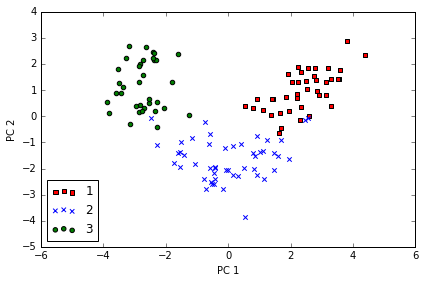

In [12]:
X_train_pca = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train == l, 0], 
                X_train_pca[y_train == l, 1], 
                c=c, label=l, marker=m)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('./figures/pca2.png', dpi=300)
plt.show()

Notice the nicely formed clusters, even though PCA does not consider class labels (unsupervised).

In [13]:
X_train_std[0].dot(w)

array([ 2.59891628,  0.00484089])

What happens if we use the last two eigen-vectors?

In [14]:
w_tail = np.hstack((eigen_pairs[-1][1][:, np.newaxis],
                    eigen_pairs[-2][1][:, np.newaxis]))
print('Matrix W (tail end):\n', w_tail)

Matrix W (tail end):
 [[-0.05546872  0.27566086]
 [ 0.03327316 -0.0813845 ]
 [-0.10061857 -0.01297513]
 [ 0.05616586  0.0989088 ]
 [ 0.09584239 -0.09592977]
 [-0.42126512  0.28389764]
 [ 0.8472247   0.11672921]
 [ 0.1662568  -0.03965663]
 [-0.16619747  0.08606027]
 [ 0.03961736 -0.57165189]
 [-0.10538369 -0.19884453]
 [-0.09950556 -0.65086971]
 [-0.01606618  0.07123771]]


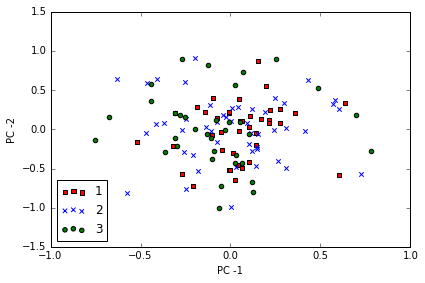

In [15]:
X_train_pca = X_train_std.dot(w_tail)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train == l, 0], 
                X_train_pca[y_train == l, 1], 
                c=c, label=l, marker=m)

plt.xlabel('PC -1')
plt.ylabel('PC -2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('./figures/pca2.png', dpi=300)
plt.show()

Notice the badly formed clusters!

## Principal component analysis in scikit-learn

PCA is actually part of scikit-learn, so we can use it directly instead of going through the code above.

In [16]:
from sklearn.decomposition import PCA

pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([ 0.37329648,  0.18818926,  0.10896791,  0.07724389,  0.06478595,
        0.04592014,  0.03986936,  0.02521914,  0.02258181,  0.01830924,
        0.01635336,  0.01284271,  0.00642076])

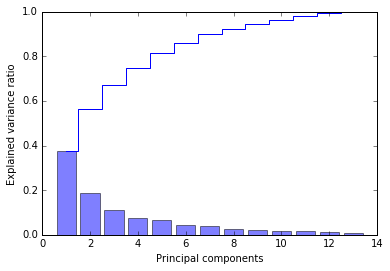

In [17]:
plt.bar(range(1, 14), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.step(range(1, 14), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.show()

In [18]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

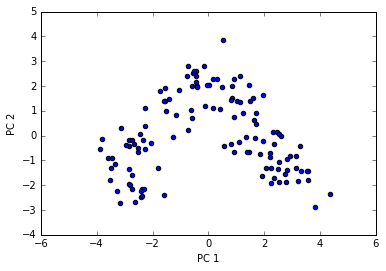

In [19]:
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

In [20]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=cmap(idx),
                    marker=markers[idx], label=cl)

Training logistic regression classifier using the first 2 principal components.

In [21]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr = lr.fit(X_train_pca, y_train)

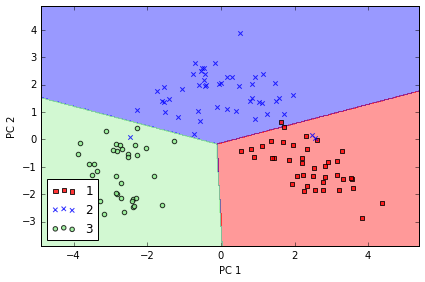

In [22]:
plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('./figures/pca3.png', dpi=300)
plt.show()

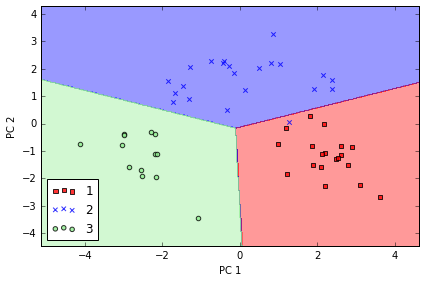

In [23]:
plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('./figures/pca4.png', dpi=300)
plt.show()

In [24]:
pca = PCA(n_components=None)
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([ 0.37329648,  0.18818926,  0.10896791,  0.07724389,  0.06478595,
        0.04592014,  0.03986936,  0.02521914,  0.02258181,  0.01830924,
        0.01635336,  0.01284271,  0.00642076])

# Supervised data compression via linear discriminant analysis

PCA
* unsupervised (no class information)
* project data into dimensions that maximize variance/spread

LDA
* supervised (with class information)
* project data into dimensions to (1) maximize inter-class spread, (2) minimize intra-class spread.

<img src='./images/05_06.png' width=40%>

### Exercise
Under what circumstances would PCA and LDA produce very different results? Provide some intuitive examples.

## Algorithm

Similar to PCA, given a data matrix $\mathbf{X}$, we want to calculate a projection matrix $\mathbf{W}$ which separates the projected vectors as much as possible.
Unlike PCA which is unsupervised, for LDA we have the class information.
Thus, the goal is to spread out different classes while cluster each individual classes via projection $\mathbf{W}$.

Assume we have $K$ classes, each with center $\mu_{i}$ as computed from the mean of all $n_i$ samples within class $i$.
$\mu$ is the mean of all samples across all classes.

We first compute the between-class scatter matrix:
$$\mathbf{S_B} = \sum_{i=1}^K n_i (\mu_i - \mu) (\mu_i - \mu)^T$$
And the within-class scatter matrix:
$$
\begin{align}
\mathbf{S_i} & = \sum_{\mathbf{x} \in C_i} (\mathbf{x} - \mu_i) (\mathbf{x} - \mu_i)^T \\
\mathbf{S_W} & = \sum_{i=1}^K \mathbf{S_i}
\end{align}
$$

<font color="blue">
Note: these scatter matrices are very similar to the covariance matrices except for scaling constants.
</font>

We then perform eigen decomposition of 
$$\mathbf{S_W}^{-1}\mathbf{S_B}$$
And construct $\mathbf{W}$ from the first $k$ eigen-vectors with the largest eigen-values.
This step is similar to PCA, except that we use the above matrix instead of $\Sigma$, the covariance matrix of all input data $\mathbf{X}$.

Intuitively, since we want to maximize the spread with $\mathbf{S_B}$ and minimize the spread with $\mathbf{S_W}$, we want to perform the eigen decomposition via $\mathbf{S_W}^{-1}\mathbf{S_B}$.

## Math
Below, we first discuss how to compute such inter and intra class spreads, followed by how to optimize $\mathbf{W}$.

The between/inter-class spread can be computed as the scatter/covariance of the projected class centers weighted by the class sizes:
$$\sum_{i=1}^K  n_i \left(\mathbf{W}^T (\mu_i - \mu) \right)^2 = \mathbf{W}^T \left( \sum_{i=1}^K n_i (\mu_i - \mu) (\mu_i - \mu)^T \right) \mathbf{W} = \mathbf{W}^T \mathbf{S_B}\mathbf{W}$$

The within/intra-class spread of each projected class $i$ can be computed analogously:
$$\sum_{\mathbf{x} \in C_i} \left(\mathbf{W}^T (\mathbf{x}-\mu_i)\right)^2 = \mathbf{W}^T \mathbf{S_i} \mathbf{W}$$
And thus the total within/intra-class spread is:
$$\sum_{i=1}^K \mathbf{W}^T \mathbf{S_i} \mathbf{W} = \mathbf{W}^T \mathbf{S_W} \mathbf{W}$$

The goal of maximize/minimize inter/intra-class spread can be formulated as maximizing the ratio of determinants:
$$J(\mathbf{W}) = \frac{\left|\mathbf{W}^T \mathbf{S_B} \mathbf{W}\right|}{\left|\mathbf{W}^T \mathbf{S_W} \mathbf{W}\right|}$$

Recall that the determinant of a matrix is the product of its eigen-values.

Linear algebra can show that constructing $\mathbf{W}$ from the largest eigen-vectors of $\mathbf{S_W}^{-1}\mathbf{S_B}$ can maximize $J(\mathbf{W})$ above. 

## Code example

Computing the scatter matrices

Calculate the mean vectors for each class:

In [25]:
np.set_printoptions(precision=4)

mean_vecs = []
for label in range(1, 4):
    mean_vecs.append(np.mean(X_train_std[y_train == label], axis=0))
    print('MV %s: %s\n' % (label, mean_vecs[label - 1]))

MV 1: [ 0.9259 -0.3091  0.2592 -0.7989  0.3039  0.9608  1.0515 -0.6306  0.5354
  0.2209  0.4855  0.798   1.2017]

MV 2: [-0.8727 -0.3854 -0.4437  0.2481 -0.2409 -0.1059  0.0187 -0.0164  0.1095
 -0.8796  0.4392  0.2776 -0.7016]

MV 3: [ 0.1637  0.8929  0.3249  0.5658 -0.01   -0.9499 -1.228   0.7436 -0.7652
  0.979  -1.1698 -1.3007 -0.3912]



Compute the within-class scatter matrix:

In [26]:
d = 13  # number of features
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.zeros((d, d))  # scatter matrix for each class
    for row in X_train_std[y_train == label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)  # make column vectors
        class_scatter += (row - mv).dot((row - mv).T)
    S_W += class_scatter                          # sum class scatter matrices

print('Within-class scatter matrix: %sx%s' % (S_W.shape[0], S_W.shape[1]))

Within-class scatter matrix: 13x13


Better: covariance matrix since classes are not equally distributed:

In [27]:
print('Class label distribution: %s' 
      % np.bincount(y_train)[1:])

Class label distribution: [40 49 35]


In [28]:
d = 13  # number of features
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train == label].T)
    S_W += class_scatter
print('Scaled within-class scatter matrix: %sx%s' % (S_W.shape[0],
                                                     S_W.shape[1]))

Scaled within-class scatter matrix: 13x13


Compute the between-class scatter matrix:

In [29]:
mean_overall = np.mean(X_train_std, axis=0)
d = 13  # number of features
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train[y_train == i + 1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1)  # make column vector
    mean_overall = mean_overall.reshape(d, 1)  # make column vector
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)

print('Between-class scatter matrix: %sx%s' % (S_B.shape[0], S_B.shape[1]))

Between-class scatter matrix: 13x13


## Selecting linear discriminants for the new feature subspace

Solve the generalized eigenvalue problem for the matrix $S_W^{-1}S_B$:

In [30]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

**Note**:
    
Above, I used the [`numpy.linalg.eig`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eig.html) function to decompose the symmetric covariance matrix into its eigenvalues and eigenvectors.
    <pre>>>> eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)</pre>
    This is not really a "mistake," but probably suboptimal. It would be better to use [`numpy.linalg.eigh`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eigh.html) in such cases, which has been designed for [Hermetian matrices](https://en.wikipedia.org/wiki/Hermitian_matrix). The latter always returns real  eigenvalues; whereas the numerically less stable `np.linalg.eig` can decompose nonsymmetric square matrices, you may find that it returns complex eigenvalues in certain cases. (S.R.)


Sort eigenvectors in decreasing order of the eigenvalues:

In [31]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues

print('Eigenvalues in decreasing order:\n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

Eigenvalues in decreasing order:

452.721581245
156.43636122
7.19589628751e-14
5.68434188608e-14
3.81852082594e-14
2.7235398212e-14
2.7235398212e-14
2.67247705375e-14
2.67247705375e-14
1.19267702437e-14
1.19267702437e-14
1.10185855395e-14
1.16091559497e-15


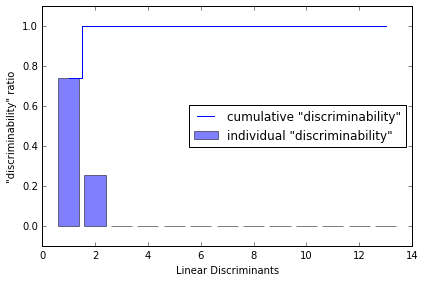

In [32]:
tot = sum(eigen_vals.real)
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)

plt.bar(range(1, 14), discr, alpha=0.5, align='center',
        label='individual "discriminability"')
plt.step(range(1, 14), cum_discr, where='mid',
         label='cumulative "discriminability"')
plt.ylabel('"discriminability" ratio')
plt.xlabel('Linear Discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('./figures/lda1.png', dpi=300)
plt.show()

In [33]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real,
              eigen_pairs[1][1][:, np.newaxis].real))
print('Matrix W:\n', w)

Matrix W:
 [[-0.0662 -0.3797]
 [ 0.0386 -0.2206]
 [-0.0217 -0.3816]
 [ 0.184   0.3018]
 [-0.0034  0.0141]
 [ 0.2326  0.0234]
 [-0.7747  0.1869]
 [-0.0811  0.0696]
 [ 0.0875  0.1796]
 [ 0.185  -0.284 ]
 [-0.066   0.2349]
 [-0.3805  0.073 ]
 [-0.3285 -0.5971]]


## Projecting samples onto the new feature space

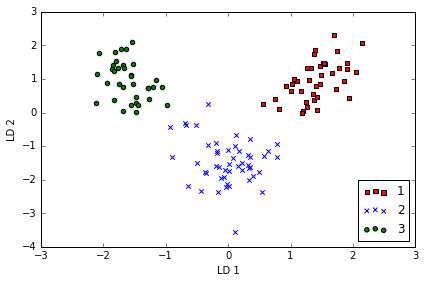

In [34]:
X_train_lda = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train == l, 0] * (-1),
                X_train_lda[y_train == l, 1] * (-1),
                c=c, label=l, marker=m)

plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.tight_layout()
# plt.savefig('./figures/lda2.png', dpi=300)
plt.show()

## LDA via scikit-learn

In [35]:
#from sklearn.lda import LDA # deprecated
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

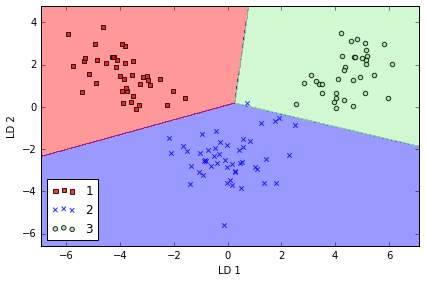

In [36]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr = lr.fit(X_train_lda, y_train)

plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('./images/lda3.png', dpi=300)
plt.show()

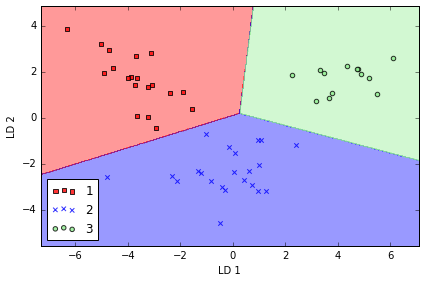

In [37]:
X_test_lda = lda.transform(X_test_std)

plot_decision_regions(X_test_lda, y_test, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('./images/lda4.png', dpi=300)
plt.show()

# Using kernel principal component analysis for nonlinear mappings


PCA/LDA problematic for non-linearly separable data

Idea:
1. elevate the dimension of the input data (similar to kernel SVM)
2. reduce the dimension (similar to PCA)

Projected data becomes linearly separable

Thus:
* the projected data can then be handled by linear classifiers
* why it make sense to increase dimension before reduce it

<img src='./images/05_11.png' width=80%>

<font color="blue">
Note: PCA is unsupervised, but it matters whether the projected data is suitable for further classification.
</font>

## Algorithm

Let $\mathbf{X}$ be the usual matrix of the input data set, with size $n \times d$, where $n$ is the number of data vectors and $d$ is their dimensionality.

Similar to kernel SVM, we want to elevate each data vector into a higher $k$-dimensional space via a function $\phi$ (usually $k >> d$).

Specifically, we denote $\phi(\mathbf{X})$ as the matrix for which the ith row is $\phi(X^{(i)})$.

Ordinary PCA performs eigen analysis of the covariance matrix of $\mathbf{X}$:
$$\Sigma = \frac{1}{n} \mathbf{X}^T \mathbf{X} $$

Kernel PCA performs eigen analysis of the elevated covariance matrix:
$$\Sigma = \frac{1}{n} \phi(\mathbf{X})^T \phi(\mathbf{X})$$

Now $\Sigma$ is of size $k \times k$, which is very large and thus expensive to compute.

Fortunately, all we need to know is to
1. compute its eigen vectors
2. project all input vectors into the lower dimensional space formed by the selected eigen vectors (with largest eigen values similar to traditional PCA)

That is, we actually never need to know the eigen vectors explicitly, only their dot products with the input vectors.
This is where the kernel trick comes in, by replacing high dimensional dot products with fast kernel evaluations.

Specifically, we just need to compute 
$$
\mathbf{K} = \phi(\mathbf{X}) \phi(\mathbf{X})^T
$$
, a $n \times n$ matrix, much smaller than $\Sigma$, via kernel trick.

The projection of $\phi(\mathbf{X})$ into $m$-dimension can be found from the $m$ largest eigen-vectors of $\mathbf{K}$.

## Math

$$\Sigma = \frac{1}{n} \phi(\mathbf{X})^T \phi(\mathbf{X})$$

Let $\mathbf{v}$ be an eigen vector of $\Sigma$ with eigen value $\lambda$:
$$\Sigma \mathbf{v} = \lambda \mathbf{v}$$

And for the elevated data matrix $\phi(\mathbf{X})$, we just need to know its projection with $\mathbf{v}$:
$$\mathbf{a} = \phi(\mathbf{X}) \mathbf{v}$$

Note that
$$
\begin{align}
\mathbf{a} &= \phi(\mathbf{X}) \mathbf{v} 
\\
&= \frac{1}{\lambda} \phi(\mathbf{X}) \Sigma \mathbf{v} 
\\
&= \frac{1}{\lambda n} \phi(\mathbf{X}) \phi(\mathbf{X})^T \phi(\mathbf{X}) \mathbf{v} 
\\
&= \frac{1}{\lambda n} \phi(\mathbf{X}) \phi(\mathbf{X})^T \mathbf{a}
\end{align}
$$

If we denote
$$\mathbf{K} = \phi(\mathbf{X}) \phi(\mathbf{X})^T$$
we have
$$\lambda \mathbf{a} = \frac{\mathbf{K}}{n} \mathbf{a}$$

<font color="blue">
Note: $\Sigma$ and $\frac{\mathbf{K}}{n}$ have the same eigen values
</font>

Thus, $\mathbf{a}$ can be computed as an eigen vector of $\frac{\mathbf{K}}{n}$, where $\mathbf{K}$, the similarity (kernel) matrix, has size $n \times n$ is thus much smaller than $\Sigma$ with size $k \times k$.

Furthermore, each entry of $\mathbf{K}$ can be computed via fast kernel evaluation
$$\mathbf{K}_{ij} = \mathbf{k}\left(\mathbf{x}^{(i)}, \mathbf{x}^{(j)}\right)$$
instead of the original dot product between two $k$-dimensional vectors 
$$\mathbf{K}_{ij} = \phi\left(\mathbf{x^{(i)}})^T \phi(\mathbf{x^{(j)}}\right)$$

This so called kernel trick, of approximating high dimensional dot products with fast kernel evaluatioin, shows up again, after what we have seen in the kernel SVM part.

### Mean shift

Recall that in (ordinary) PCA, each entry of $\Sigma$ is a covariance:
$$\Sigma_{ij} = \frac{1}{n} (\mathbf{x_{(i)}} - \mathbf{\mu_i})^T (\mathbf{x_{(j)}} - \mathbf{\mu_j})$$
, where $\mathbf{\mu}$ is the mean of all $\mathbf{x}$, i.e. the rows of $\mathbf{X}$.

For kernel PCA, we need to perform a similar mean shift for $\mathbf{K}$.
Specifically, since $\mathbf{K}$ is the covariance matrix of $\phi(\mathbf{x})$, we have
$$\mathbf{\mu} = \frac{1}{n} \sum_{k=1}^n \phi(x^{(k)})$$
And each entry of the mean-shifted $\mathbf{K'}$ is:
$$
\begin{align}
\mathbf{K'}_{ij} & = \left(\phi(\mathbf{x^{(i)}}) - \mathbf{\mu}\right)^T \left(\phi(\mathbf{x^{(j)}}) - \mathbf{\mu}\right) \\
& = \phi(\mathbf{x^{(i)}})^T \phi(\mathbf{x^{(j)}}) - \mathbf{\mu}^T \phi(\mathbf{x^{(j)}}) - \phi(\mathbf{x^{(i)}})^T \mathbf{\mu} + \mathbf{\mu}^T \mathbf{\mu} \\
& = \mathbf{k}(\mathbf{x^{(i)}}, \mathbf{x^{(j)}}) - \frac{1}{n} \sum_{i=1}^n \mathbf{k}(\mathbf{x^{(i)}}, \mathbf{x^{(j)}}) - \frac{1}{n} \sum_{j=1}^n \mathbf{k}(\mathbf{x^{(i)}}, \mathbf{x^{(j)}}) 
\\
&+ \frac{1}{n^2} \sum_{i=1}^n \sum_{j=1}^n \mathbf{k}(\mathbf{x^{(i)}}, \mathbf{x^{(j)}})
\end{align}
$$
Coalescing all entries $\mathbf{K'_{ij}}$ into $\mathbf{K'}$ we have
$$\mathbf{K'} = \mathbf{K} - \mathbf{1_n} \mathbf{K} - \mathbf{K} \mathbf{1_n} + \mathbf{1_n} \mathbf{K} \mathbf{1_n}$$
where $\mathbf{1_n}$ is a matrix of the same size as $\mathbf{K}$ with all entries equal to $\frac{1}{n}$.

### New data set

In the above we perform kernel PCA for a given dataset $\mathbf{X}$.
How about a new dataset, such as a test data $\mathbf{X'}$, which is not part of $\mathbf{X}$?

In ordinary PCA, we can simply project $\mathbf{X'}$ through $\mathbf{W}$, the matrix whose columns are the (selected) eigen-vectors of $\Sigma$:
$$\mathbf{X'} \mathbf{W}$$

However, for kernel PCA, we only compute the eigen-vectors of the (mean-shifted) kernel matrix $\mathbf{K}$, not the original covariance matrix $\Sigma$.
Fortunately, we can accomplish our goal via smart math tricks, as follows.

First, let's express each eigen-vector $\mathbf{v}$ of $\Sigma$ via the eigen-vectors $\mathbf{A}$ of $\mathbf{K}$.
Recall
$$
\begin{align}
\mathbf{v} 
&= 
\frac{1}{\lambda} \Sigma \mathbf{v} 
\\
&= 
\frac{1}{n \lambda} \phi(\mathbf{X})^T \phi(\mathbf{X}) \mathbf{v} 
\\
&= 
\frac{1}{n \lambda} \phi(\mathbf{X})^T \mathbf{a}
\\
&=
\frac{1}{n \lambda} \sum_{i=1}^n \mathbf{a^{(i)}} \phi(\mathbf{x}^{(i)})
\end{align}
$$

Thus, to project a new sample $\mathbf{x'}$ with an eigen vector $\mathbf{v}$, we can use the kernel trick again with the already computed $\mathbf{a}$ vectors:
$$
\begin{align}
\phi(\mathbf{x'})^T \mathbf{v} &=
\frac{1}{n \lambda} \sum_{i=1}^n \mathbf{a}^{(i)} \phi(\mathbf{x'})^T \phi(\mathbf{x}^{(i)})
\\
&=
\frac{1}{n \lambda} \sum_{i=1}^n \mathbf{a^{(i)}} \mathbf{k}(\mathbf{x'}, \mathbf{x^{(i)}})
\end{align}
$$

## Implementing a kernel principal component analysis in Python

Code the math above ...

In [38]:
from scipy.spatial.distance import pdist, squareform
from scipy import exp
from scipy.linalg import eigh
import numpy as np

def rbf_kernel_pca(X, gamma, n_components):
    """
    RBF kernel PCA implementation.

    Parameters
    ------------
    X: {NumPy ndarray}, shape = [n_samples, n_features]
        
    gamma: float
      Tuning parameter of the RBF kernel
        
    n_components: int
      Number of principal components to return

    Returns
    ------------
     X_pc: {NumPy ndarray}, shape = [n_samples, k_features]
       Projected dataset   

    """
    # Calculate pairwise squared Euclidean distances
    # in the MxN dimensional dataset.
    sq_dists = pdist(X, 'sqeuclidean')

    # Convert pairwise distances into a square matrix.
    mat_sq_dists = squareform(sq_dists)

    # Compute the symmetric kernel matrix.
    K = exp(-gamma * mat_sq_dists)

    # Center the kernel matrix.
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

    # Obtaining eigenpairs from the centered kernel matrix
    # numpy.eigh returns them in sorted order
    eigvals, eigvecs = eigh(K)

    # Collect the top k eigenvectors (projected samples)
    X_pc = np.column_stack((eigvecs[:, -i]
                            for i in range(1, n_components + 1)))

    return X_pc

### Example 1: Separating half-moon shapes

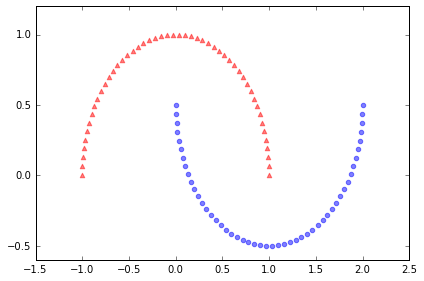

In [39]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, random_state=123)

plt.scatter(X[y == 0, 0], X[y == 0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', marker='o', alpha=0.5)

plt.tight_layout()
# plt.savefig('./figures/half_moon_1.png', dpi=300)
plt.show()

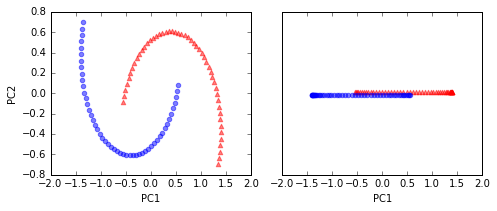

In [40]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))

ax[0].scatter(X_spca[y == 0, 0], X_spca[y == 0, 1],
              color='red', marker='^', alpha=0.5)
ax[0].scatter(X_spca[y == 1, 0], X_spca[y == 1, 1],
              color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_spca[y == 0, 0], np.zeros((50, 1)) + 0.02,
              color='red', marker='^', alpha=0.5)
ax[1].scatter(X_spca[y == 1, 0], np.zeros((50, 1)) - 0.02,
              color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.tight_layout()
# plt.savefig('./figures/half_moon_2.png', dpi=300)
plt.show()

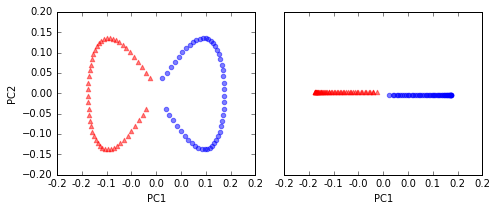

In [41]:
from matplotlib.ticker import FormatStrFormatter

X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)

fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(7,3))
ax[0].scatter(X_kpca[y==0, 0], X_kpca[y==0, 1], 
            color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y==1, 0], X_kpca[y==1, 1],
            color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_kpca[y==0, 0], np.zeros((50,1))+0.02, 
            color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y==1, 0], np.zeros((50,1))-0.02,
            color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')
ax[0].xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
ax[1].xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))

plt.tight_layout()
# plt.savefig('./figures/half_moon_3.png', dpi=300)
plt.show()

### Example 2: Separating concentric circles

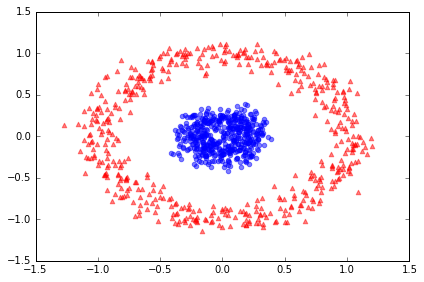

In [42]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=1000, random_state=123, noise=0.1, factor=0.2)

plt.scatter(X[y == 0, 0], X[y == 0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', marker='o', alpha=0.5)

plt.tight_layout()
# plt.savefig('./figures/circles_1.png', dpi=300)
plt.show()

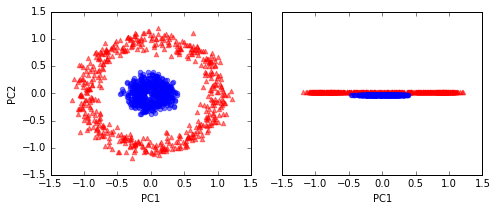

In [43]:
scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))

ax[0].scatter(X_spca[y == 0, 0], X_spca[y == 0, 1],
              color='red', marker='^', alpha=0.5)
ax[0].scatter(X_spca[y == 1, 0], X_spca[y == 1, 1],
              color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_spca[y == 0, 0], np.zeros((500, 1)) + 0.02,
              color='red', marker='^', alpha=0.5)
ax[1].scatter(X_spca[y == 1, 0], np.zeros((500, 1)) - 0.02,
              color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.tight_layout()
# plt.savefig('./figures/circles_2.png', dpi=300)
plt.show()

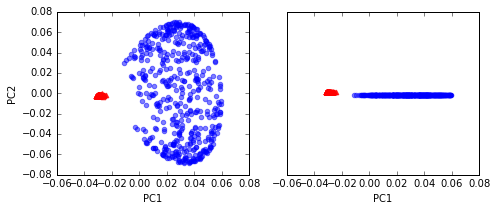

In [44]:
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
ax[0].scatter(X_kpca[y == 0, 0], X_kpca[y == 0, 1],
              color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y == 1, 0], X_kpca[y == 1, 1],
              color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_kpca[y == 0, 0], np.zeros((500, 1)) + 0.02,
              color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y == 1, 0], np.zeros((500, 1)) - 0.02,
              color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.tight_layout()
# plt.savefig('./figures/circles_3.png', dpi=300)
plt.show()

## Projecting new data points

Note the code below computes eigen values of $\mathbf{K}$ instead of $\frac{\mathbf{K}}{n}$, and thus the eigen values will be $n \times$ scaled.

In [45]:
from scipy.spatial.distance import pdist, squareform
from scipy import exp
from scipy.linalg import eigh
import numpy as np

def rbf_kernel_pca(X, gamma, n_components):
    """
    RBF kernel PCA implementation.

    Parameters
    ------------
    X: {NumPy ndarray}, shape = [n_samples, n_features]
        
    gamma: float
      Tuning parameter of the RBF kernel
        
    n_components: int
      Number of principal components to return

    Returns
    ------------
     X_pc: {NumPy ndarray}, shape = [n_samples, k_features]
       Projected dataset   
     
     lambdas: list
       Eigenvalues

    """
    # Calculate pairwise squared Euclidean distances
    # in the MxN dimensional dataset.
    sq_dists = pdist(X, 'sqeuclidean')

    # Convert pairwise distances into a square matrix.
    mat_sq_dists = squareform(sq_dists)

    # Compute the symmetric kernel matrix.
    K = exp(-gamma * mat_sq_dists)

    # Center the kernel matrix.
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

    # Obtaining eigenpairs from the centered kernel matrix
    # numpy.eigh returns them in sorted order
    eigvals, eigvecs = eigh(K)

    # Collect the top k eigenvectors (projected samples)
    alphas = np.column_stack((eigvecs[:, -i]
                              for i in range(1, n_components + 1)))

    # Collect the corresponding eigenvalues
    lambdas = [eigvals[-i] for i in range(1, n_components + 1)]

    return alphas, lambdas

In [46]:
def project_x(x_new, X, gamma, alphas, lambdas):
    pair_dist = np.array([np.sum((x_new - row)**2) for row in X])
    k = np.exp(-gamma * pair_dist)
    return k.dot(alphas / lambdas)

In [47]:
X, y = make_moons(n_samples=100, random_state=123)
alphas, lambdas = rbf_kernel_pca(X, gamma=15, n_components=1)

In [48]:
select_new = -1
x_new = X[select_new]
x_new

array([ 0.4816, -0.3551])

In [49]:
x_proj = alphas[select_new] # original projection

# projection of the "new" datapoint
x_reproj = project_x(x_new, X, gamma=15, alphas=alphas, lambdas=lambdas)

# should be the same
print(x_proj)
print(x_reproj) 

[ 0.1192]
[ 0.1192]


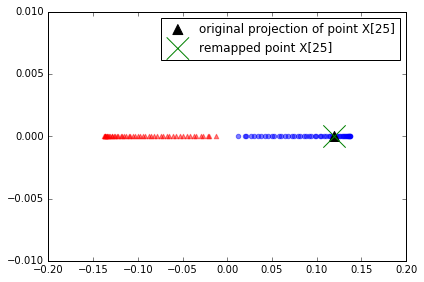

In [50]:
plt.scatter(alphas[y == 0, 0], np.zeros((50)),
            color='red', marker='^', alpha=0.5)
plt.scatter(alphas[y == 1, 0], np.zeros((50)),
            color='blue', marker='o', alpha=0.5)
plt.scatter(x_proj, 0, color='black',
            label='original projection of point X[25]', marker='^', s=100)
plt.scatter(x_reproj, 0, color='green',
            label='remapped point X[25]', marker='x', s=500)
plt.legend(scatterpoints=1)

plt.tight_layout()
# plt.savefig('./figures/reproject.png', dpi=300)
plt.show()

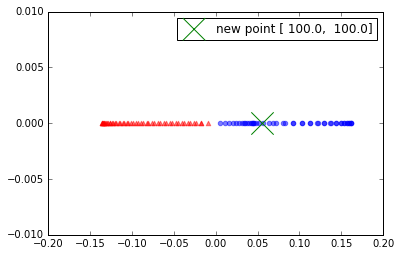

In [51]:
X, y = make_moons(n_samples=100, random_state=123)
X_1, y_1 = X[:-1, :], y[:-1]
alphas, lambdas = rbf_kernel_pca(X_1, gamma=15, n_components=1)

# projection of the "new" datapoint
x_new = X[-1, :]

x_reproj = project_x(x_new, X_1, gamma=15, alphas=alphas, lambdas=lambdas)

plt.scatter(alphas[y_1 == 0, 0], np.zeros((np.sum(y_1 == 0))),
            color='red', marker='^', alpha=0.5)
plt.scatter(alphas[y_1 == 1, 0], np.zeros((np.sum(y_1 == 1))),
            color='blue', marker='o', alpha=0.5)
plt.scatter(x_reproj, 0, color='green',
            label='new point [ 100.0,  100.0]', marker='x', s=500)
plt.legend(scatterpoints=1)


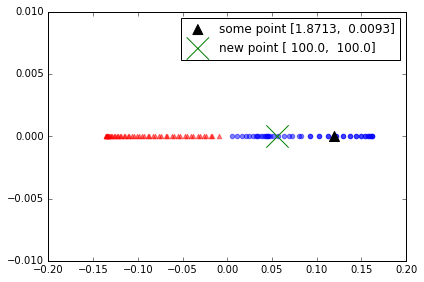

In [52]:
plt.scatter(alphas[y_1 == 0, 0], np.zeros((np.sum(y_1 == 0))),
            color='red', marker='^', alpha=0.5)
plt.scatter(alphas[y_1 == 1, 0], np.zeros((np.sum(y_1 == 1))),
            color='blue', marker='o', alpha=0.5)
plt.scatter(x_proj, 0, color='black',
            label='some point [1.8713,  0.0093]', marker='^', s=100)
plt.scatter(x_reproj, 0, color='green',
            label='new point [ 100.0,  100.0]', marker='x', s=500)
plt.legend(scatterpoints=1)

plt.tight_layout()
# plt.savefig('./figures/reproject.png', dpi=300)
plt.show()

## Kernel principal component analysis in scikit-learn

Kernel PCA is part of the scikit-learn library and can be direclty used

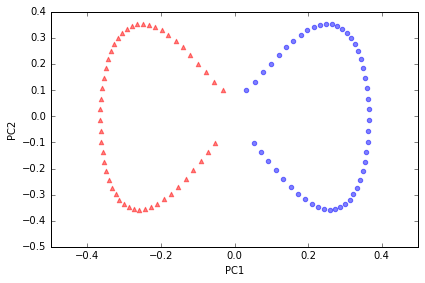

In [53]:
from sklearn.decomposition import KernelPCA

X, y = make_moons(n_samples=100, random_state=123)
scikit_kpca = KernelPCA(n_components=2, kernel='rbf', gamma=15)
X_skernpca = scikit_kpca.fit_transform(X)

plt.scatter(X_skernpca[y == 0, 0], X_skernpca[y == 0, 1],
            color='red', marker='^', alpha=0.5)
plt.scatter(X_skernpca[y == 1, 0], X_skernpca[y == 1, 1],
            color='blue', marker='o', alpha=0.5)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
# plt.savefig('./figures/scikit_kpca.png', dpi=300)
plt.show()

## Question

How should we choose between the following two?
1. Linear PCA $\rightarrow$ kernel SVM
2. kernel PCA $\rightarrow$ linear SVM

# Summary

# Reading

* PML Chapter 5
* IML Chapter 6.3, 6.6, 13.12
